In [60]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn
import torch.optim as optim
cudnn.benchmark = True  # fire on all cylinders
from tqdm import tqdm


In [61]:
from tqdm import tqdm

In [62]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [63]:
print(len(train_data))
print(test_data.__len__())

60000
10000


In [64]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [65]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")


CUDA Available:  True


In [66]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [82]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=32, shuffle=True)
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)
# Hyperparameters
# learning_rate = 0.01
# epochs = 10
# # train the model
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # Get inputs
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass, compute loss
#         outputs = model(inputs)
#         loss = F.nll_loss(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Update running loss
#         running_loss += loss.item()
#         if i % 2000 == 1999:  # Print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

# # Save the model
# model_path = "data/saved-model.pt"  # Replace with your desired filename
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")



CUDA Available:  True


In [83]:
# Load the pretrained model
pretrained_model = "data/saved-model.pt"

model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

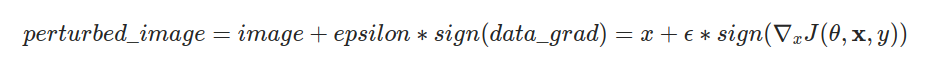

In [118]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def pgd_attack(image, epsilon, data_grad, num_steps=40, step_size=0.01):
    # Initialize the perturbed image as a copy of the original image
    perturbed_image = image.clone().detach()
    
    # Iteratively apply gradient ascent for the specified number of steps
    for _ in range(num_steps):
        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()
        # Add a small step in the direction of the sign of the gradient
        perturbed_image += step_size * sign_data_grad
        # Clip the perturbed image to stay within the epsilon budget
        perturbed_image = torch.clamp(perturbed_image, image - epsilon, image + epsilon)
        # Clip the perturbed image to ensure it stays within the valid image range [0, 1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
    return perturbed_image

def pgd_targeted_attack(image, epsilon, data_grad, target_class, alpha=0.01, num_iter=40):
    """
    Targeted Projected Gradient Descent (PGD) attack.

    Args:
        image (torch.Tensor): The original input image.
        epsilon (float): Perturbation magnitude.
        data_grad (torch.Tensor): Gradient of the loss w.r.t. the input image.
        target_class (int): Target class label for the attack.
        alpha (float, optional): Step size for perturbation updates. Defaults to 0.01.
        num_iter (int, optional): Number of iterations for the attack. Defaults to 40.

    Returns:
        torch.Tensor: Perturbed image.
    """
    # Create a copy of the original image for perturbation
    perturbed_image = image.clone().detach()
    # Iteratively apply small perturbations to the image
    for i in range(num_iter):
        # Calculate the gradient of the loss w.r.t. the image
        perturbed_image.requires_grad = True
        output = model(perturbed_image)
        loss = F.nll_loss(output, torch.tensor([target_class]).to(device))
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        # Update the image with a small step towards the direction that minimizes the loss for the target class
        perturbed_image = perturbed_image - alpha * torch.sign(data_grad)
        # Clip the perturbed image to maintain [0,1] range within epsilon bounds
        perturbed_image = torch.min(torch.max(perturbed_image, image - epsilon), image + epsilon).detach_()
    return perturbed_image


# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [125]:
def test( model, device, test_loader, epsilon,attack_type ,targeted=False):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in tqdm(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred[0].item() != target[0].item():
            continue

        # Calculate the loss
        if(targeted):
            target2=torch.tensor([3]).to(device)
            a = F.nll_loss(output, target)
            b = F.nll_loss(output, target2)
            loss = a-b
        else:
            loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)
        if attack_type == 'fgsm_attack':
        # Call FGSM Attack
            perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        elif attack_type == 'pgd_attack':
            perturbed_data = pgd_attack(data_denorm, epsilon, target)
        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred[0].item() == target[0].item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))

    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Untargetted attacks 

### FGSM

In [97]:
accuracies = []
examples = []
original = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps,'fgsm_attack')
    accuracies.append(acc)
    examples.append(ex)

100%|██████████| 10000/10000 [00:27<00:00, 357.35it/s]


Epsilon: 0	Test Accuracy = 9640 / 10000 = 0.964


100%|██████████| 10000/10000 [00:36<00:00, 275.69it/s]


Epsilon: 0.05	Test Accuracy = 8591 / 10000 = 0.8591


100%|██████████| 10000/10000 [00:32<00:00, 303.04it/s]


Epsilon: 0.1	Test Accuracy = 7050 / 10000 = 0.705


100%|██████████| 10000/10000 [00:32<00:00, 309.69it/s]


Epsilon: 0.15	Test Accuracy = 5958 / 10000 = 0.5958


100%|██████████| 10000/10000 [00:34<00:00, 293.66it/s]


Epsilon: 0.2	Test Accuracy = 5467 / 10000 = 0.5467


100%|██████████| 10000/10000 [00:32<00:00, 310.30it/s]


Epsilon: 0.25	Test Accuracy = 5222 / 10000 = 0.5222


100%|██████████| 10000/10000 [00:32<00:00, 311.46it/s]

Epsilon: 0.3	Test Accuracy = 4978 / 10000 = 0.4978


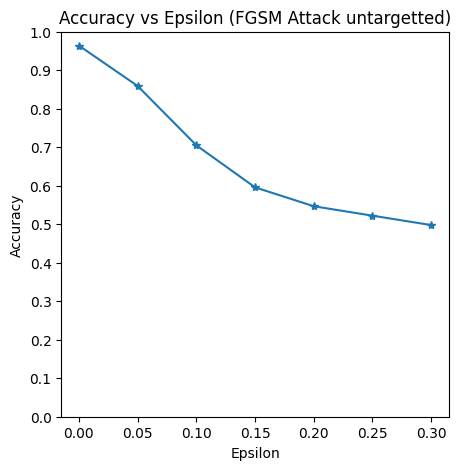

In [102]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (FGSM Attack untargetted)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

/tmp/ipykernel_16011/1624837686.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(epsilons),len(examples[0]),cnt)


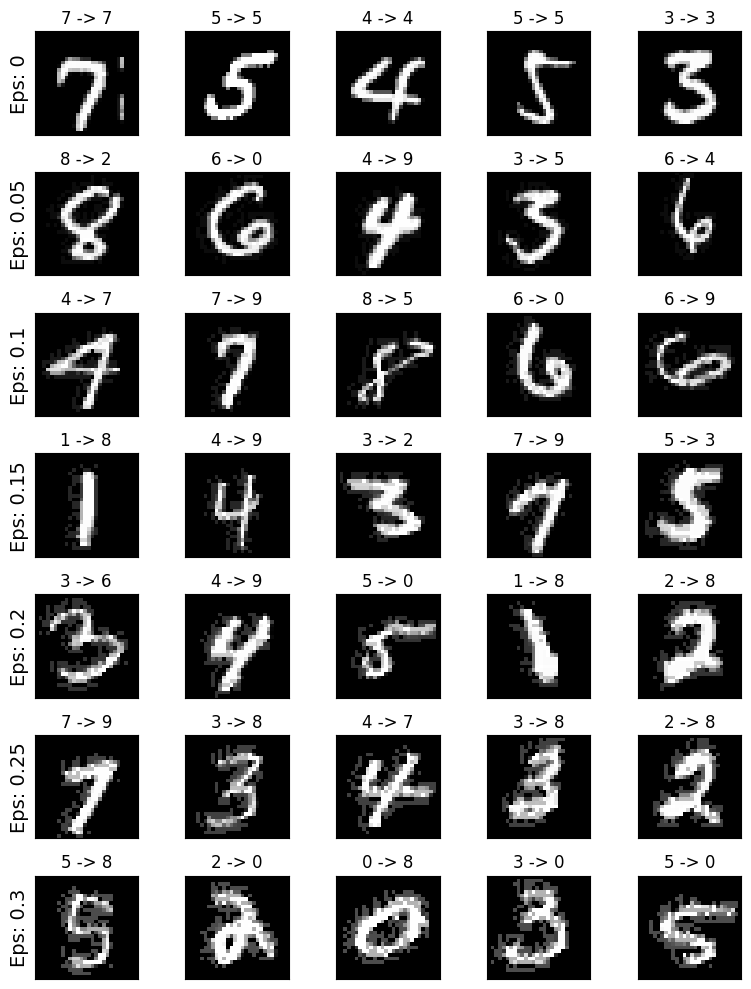

In [104]:
# Plot several examples of adversarial samples vs original at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
plt.title("FGSM undirected ")
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


### PGD

In [101]:
accuracies_pgd_un = []
examples_pgd_un = []
original_pgd_un = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, 'pgd_attack')
    accuracies_pgd_un.append(acc)
    examples_pgd_un.append(ex)

100%|██████████| 10000/10000 [00:51<00:00, 193.06it/s]


Epsilon: 0	Test Accuracy = 9640 / 10000 = 0.964


100%|██████████| 10000/10000 [00:58<00:00, 170.63it/s]


Epsilon: 0.05	Test Accuracy = 9433 / 10000 = 0.9433


100%|██████████| 10000/10000 [00:56<00:00, 175.78it/s]


Epsilon: 0.1	Test Accuracy = 3362 / 10000 = 0.3362


100%|██████████| 10000/10000 [00:54<00:00, 182.29it/s]


Epsilon: 0.15	Test Accuracy = 1987 / 10000 = 0.1987


100%|██████████| 10000/10000 [00:54<00:00, 184.82it/s]


Epsilon: 0.2	Test Accuracy = 1884 / 10000 = 0.1884


100%|██████████| 10000/10000 [00:55<00:00, 181.27it/s]


Epsilon: 0.25	Test Accuracy = 1884 / 10000 = 0.1884


100%|██████████| 10000/10000 [00:56<00:00, 178.31it/s]

Epsilon: 0.3	Test Accuracy = 1884 / 10000 = 0.1884


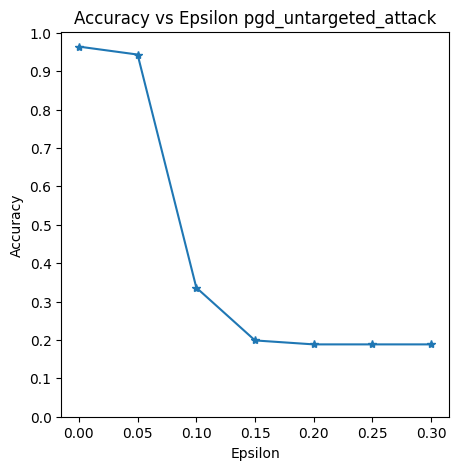

In [103]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_pgd_un, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon pgd_untargeted_attack")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

/tmp/ipykernel_16011/3629087047.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(epsilons),len(examples_pgd_un[0]),cnt)


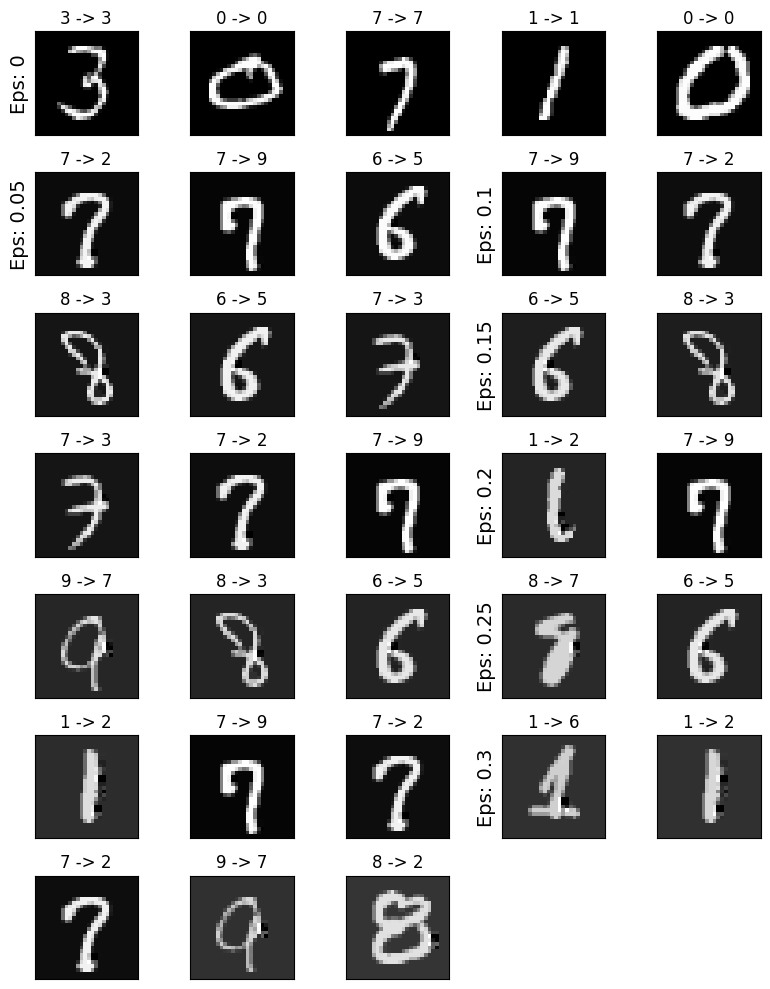

In [92]:
# Plot several examples of adversarial samples vs original at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
plt.title("pgd undirected ")
for i in range(len(epsilons)):
    for j in range(len(examples_pgd_un[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_pgd_un[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples_pgd_un[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

#compare the original and adversarial images
# original and adversarial images


## Targetted attacks

### FGSM

In [113]:
accuracies_FGSM_T = []
examples_FGSM_T = []
original_FGSM_T = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps,'fgsm_attack',True)
    accuracies_FGSM_T.append(acc)
    examples_FGSM_T.append(ex)

100%|██████████| 10000/10000 [00:30<00:00, 327.82it/s]


Epsilon: 0	Test Accuracy = 9640 / 10000 = 0.964


100%|██████████| 10000/10000 [00:35<00:00, 284.33it/s]


Epsilon: 0.05	Test Accuracy = 8850 / 10000 = 0.885


100%|██████████| 10000/10000 [00:35<00:00, 282.36it/s]


Epsilon: 0.1	Test Accuracy = 7457 / 10000 = 0.7457


100%|██████████| 10000/10000 [00:34<00:00, 285.95it/s]


Epsilon: 0.15	Test Accuracy = 6445 / 10000 = 0.6445


100%|██████████| 10000/10000 [00:37<00:00, 270.09it/s]


Epsilon: 0.2	Test Accuracy = 6014 / 10000 = 0.6014


100%|██████████| 10000/10000 [00:38<00:00, 257.23it/s]


Epsilon: 0.25	Test Accuracy = 5820 / 10000 = 0.582


100%|██████████| 10000/10000 [00:38<00:00, 260.08it/s]

Epsilon: 0.3	Test Accuracy = 5590 / 10000 = 0.559


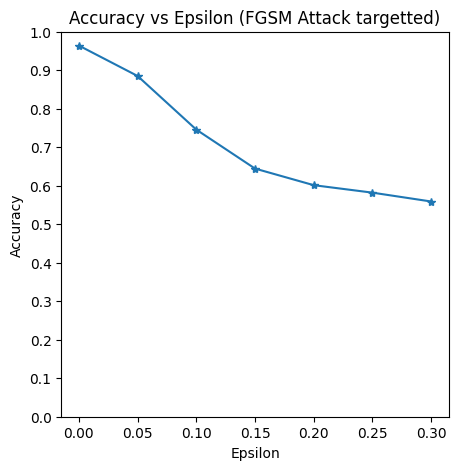

In [114]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FGSM_T, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (FGSM Attack targetted)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

/tmp/ipykernel_16011/2953975167.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(epsilons),len(examples_FGSM_T[0]),cnt)


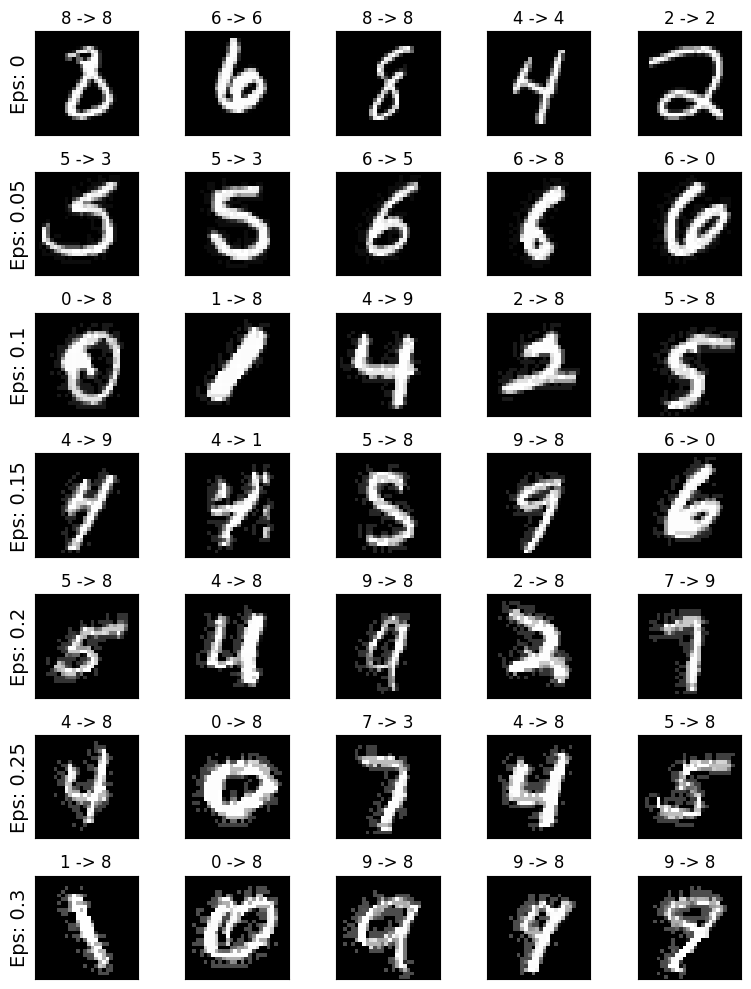

In [115]:
# Plot several examples of adversarial samples vs original at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
plt.title("pgd undirected ")
for i in range(len(epsilons)):
    for j in range(len(examples_FGSM_T[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_FGSM_T[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples_FGSM_T[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


### PGD

In [126]:
accuracies_pgd_T = []
examples_pgd_T = []
original_pgd_T = []

# Run test for each epsilon
for eps in epsilons:

    acc, ex = test(model, device, test_loader, eps, 'pgd_attack',True)
    accuracies_pgd_T.append(acc)
    examples_pgd_T.append(ex)

100%|██████████| 10000/10000 [01:01<00:00, 161.43it/s]


Epsilon: 0	Test Accuracy = 9640 / 10000 = 0.964


100%|██████████| 10000/10000 [01:04<00:00, 154.49it/s]


Epsilon: 0.05	Test Accuracy = 9433 / 10000 = 0.9106847982022364


100%|██████████| 10000/10000 [01:03<00:00, 157.67it/s]


Epsilon: 0.1	Test Accuracy = 3362 / 10000 = 0.21289101971999794


100%|██████████| 10000/10000 [01:03<00:00, 157.54it/s]


Epsilon: 0.15	Test Accuracy = 1987 / 10000 = 0.08790568337568401


100%|██████████| 10000/10000 [01:03<00:00, 158.14it/s]


Epsilon: 0.2	Test Accuracy = 1884 / 10000 = 0.14770621144115628


100%|██████████| 10000/10000 [01:03<00:00, 157.84it/s]


Epsilon: 0.25	Test Accuracy = 1884 / 10000 = 0.08810155486984116


100%|██████████| 10000/10000 [01:03<00:00, 156.89it/s]

Epsilon: 0.3	Test Accuracy = 1884 / 10000 = 0.13291263095091083


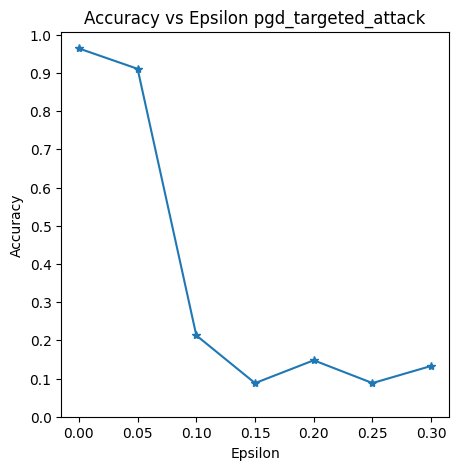

In [127]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_pgd_T, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon pgd_targeted_attack")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

/tmp/ipykernel_16011/373066110.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(epsilons),len(examples_pgd_T[0]),cnt)


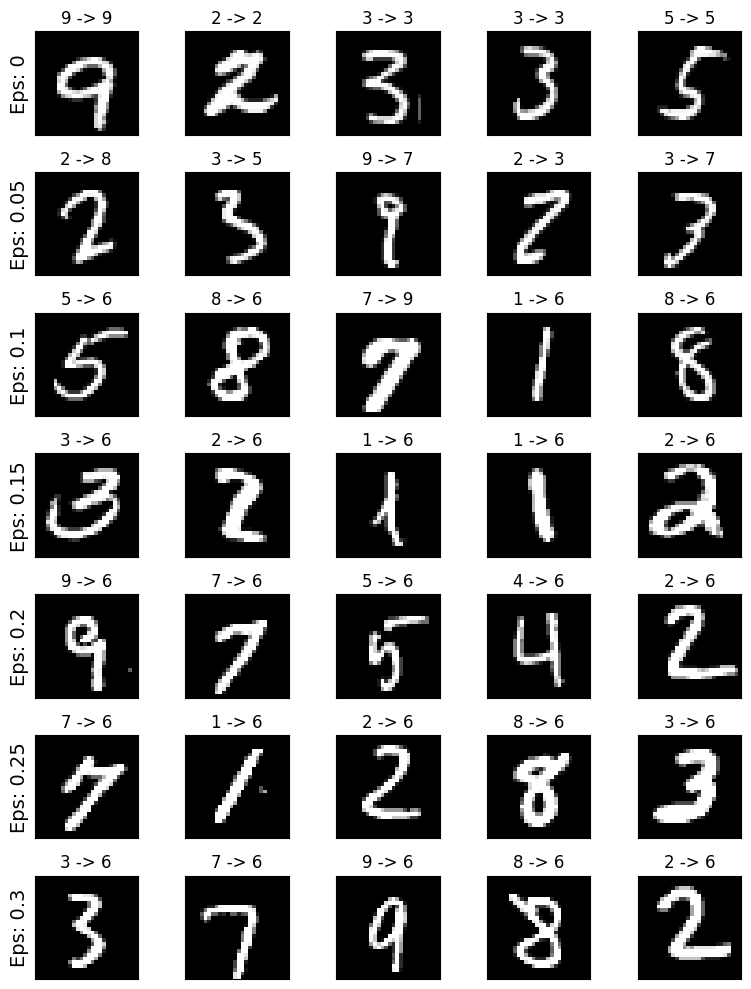

In [128]:
# Plot several examples of adversarial samples vs original at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
plt.title("pgd targetted ")
for i in range(len(epsilons)):
    for j in range(len(examples_pgd_T[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_pgd_T[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples_pgd_T[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


### Visaulization

In [129]:
model.to('cpu')

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### FGSM Untargetted

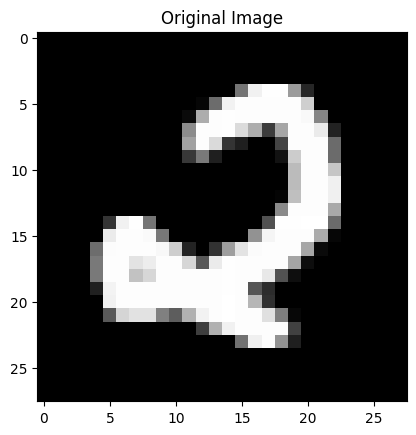

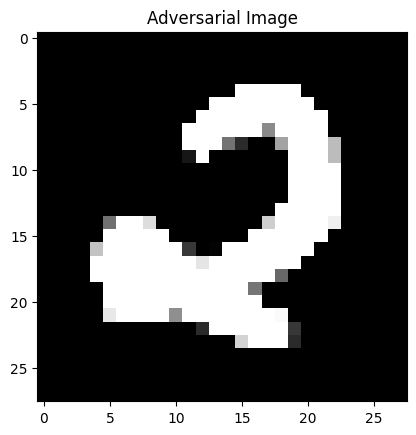

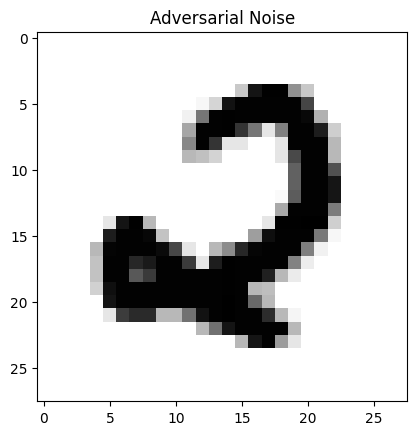

Original Label: 2
Predicted Label: 2
Original Loss: 0.0004814896092284471
Perturbed Loss: 0.0012346034636721015


In [138]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)
data , target = next(iter(test_loader))
data = data.to('cpu')
target = target.to('cpu')

# Visualize the original image
plt.imshow(data[0].numpy().squeeze(), cmap="gray")
plt.title(f"Original Image")
plt.show()

epsilon = 0.2
# Set requires_grad attribute of tensor. Important for Attack
data.requires_grad = True

output = model(data)
loss = F.nll_loss(output, target)  
model.zero_grad()
loss.backward()
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)
perturbed_data = perturbed_data.to('cpu')
# Reapply normalization
perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
# Re-classify the perturbed image
output = model(perturbed_data_normalized)

a , b = torch.max(output,1)
c,d = torch.max(output,1)

# Visualize the adversarial image and the noise

plt.imshow(perturbed_data.squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Image")
plt.show()

plt.imshow((perturbed_data - data).squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Noise")
plt.show()

#original vs predicted label
print(f"Original Label: {target.item()}")
print(f"Predicted Label: {b.item()}")

# Calculate the losses
print(f"Original Loss: {loss.item()}")
print(f"Perturbed Loss: {F.nll_loss(output, target).item()}")


### PGD Untargetted

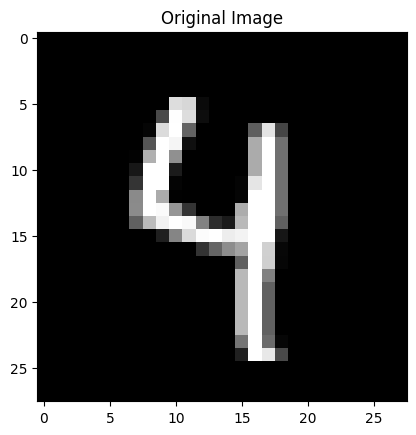

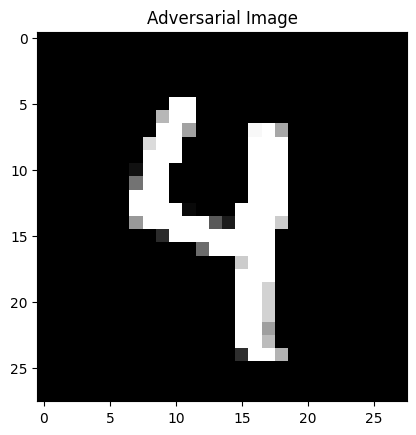

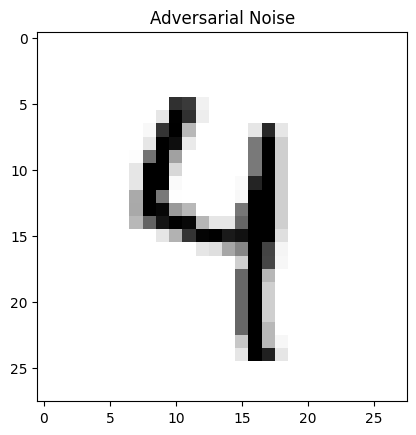

Original Label: 4
Predicted Label: 7
Original Loss: 0.003002304583787918
Perturbed Loss: 0.017240067943930626


In [144]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)
data , target = next(iter(test_loader))
data = data.to('cpu')
target = target.to('cpu')

# Visualize the original image
plt.imshow(data[0].numpy().squeeze(), cmap="gray")
plt.title(f"Original Image")
plt.show()

epsilon = 0.2
# Set requires_grad attribute of tensor. Important for Attack
data.requires_grad = True

output = model(data)
loss = F.nll_loss(output, target)  
model.zero_grad()
loss.backward()
data_grad = data.grad.data
perturbed_data = pgd_attack(data, epsilon, data_grad)
perturbed_data = perturbed_data.to('cpu')
# Reapply normalization
perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
# Re-classify the perturbed image
output = model(perturbed_data_normalized)

a , b = torch.max(output,1)
c,d = torch.max(output,1)

# Visualize the adversarial image and the noise

plt.imshow(perturbed_data.squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Image")
plt.show()

plt.imshow((perturbed_data - data).squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Noise")
plt.show()

#original vs predicted label
print(f"Original Label: {target.item()}")
print(f"Predicted Label: {b.item()}")

# Calculate the losses
print(f"Original Loss: {loss.item()}")
print(f"Perturbed Loss: {F.nll_loss(output, target).item()}")


### FGSM Targetted

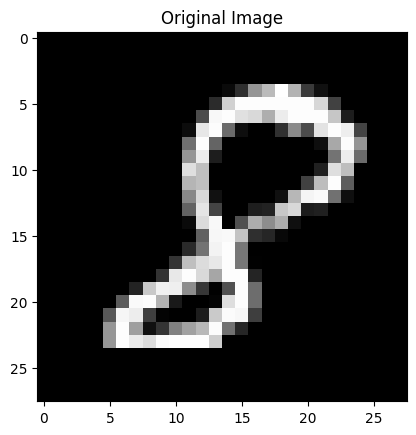

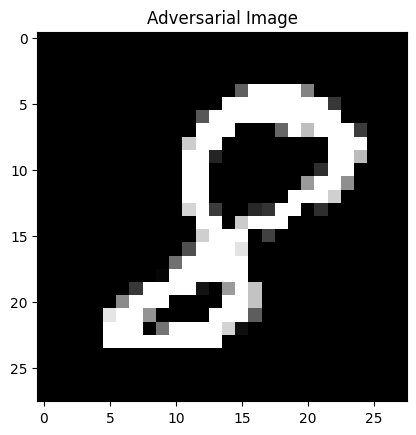

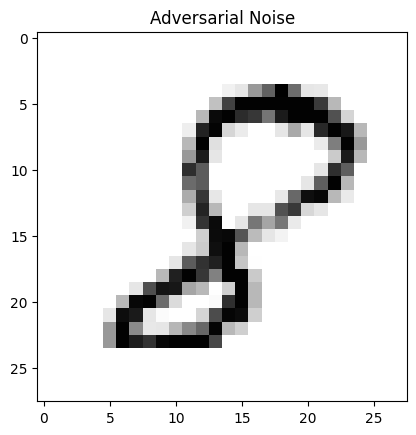

Original Label: 8
Predicted Label: 8
Original Loss: -5.619986057281494
Perturbed Loss: 0.1887313574552536


In [145]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)
data , target = next(iter(test_loader))
data = data.to('cpu')
target = target.to('cpu')

# Visualize the original image
plt.imshow(data[0].numpy().squeeze(), cmap="gray")
plt.title(f"Original Image")
plt.show()

epsilon = 0.2
# Set requires_grad attribute of tensor. Important for Attack
data.requires_grad = True

output = model(data)
f = torch.tensor([3]).to('cpu')
loss = F.nll_loss(output, target) - F.nll_loss(output, f)  
model.zero_grad()
loss.backward()
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)
perturbed_data = perturbed_data.to('cpu')
# Reapply normalization
perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
# Re-classify the perturbed image
output = model(perturbed_data_normalized)

a , b = torch.max(output,1)
c,d = torch.max(output,1)

# Visualize the adversarial image and the noise

plt.imshow(perturbed_data.squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Image")
plt.show()

plt.imshow((perturbed_data - data).squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Noise")
plt.show()

#original vs predicted label
print(f"Original Label: {target.item()}")
print(f"Predicted Label: {b.item()}")

# Calculate the losses
print(f"Original Loss: {loss.item()}")
print(f"Perturbed Loss: {F.nll_loss(output, target).item()}")


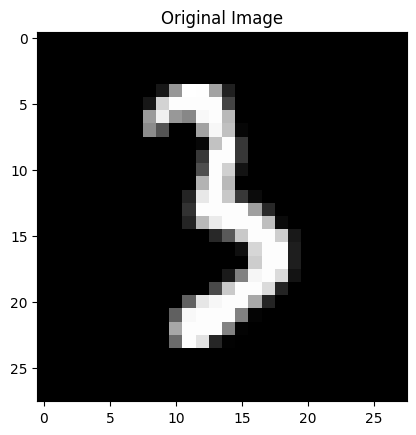

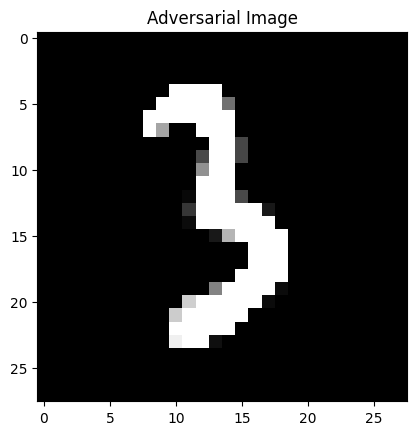

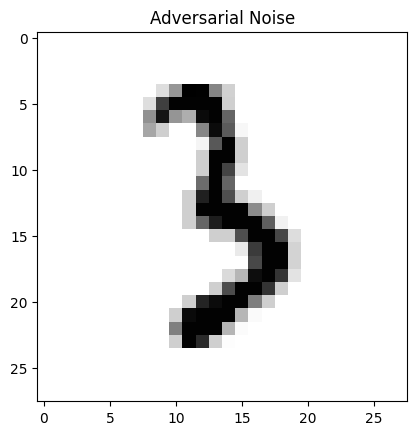

Original Label: 3
Predicted Label: 3
Original Loss: 0.0
Perturbed Loss: 0.0001908358681248501


In [148]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)
data , target = next(iter(test_loader))
data = data.to('cpu')
target = target.to('cpu')

# Visualize the original image
plt.imshow(data[0].numpy().squeeze(), cmap="gray")
plt.title(f"Original Image")
plt.show()

epsilon = 0.2
# Set requires_grad attribute of tensor. Important for Attack
data.requires_grad = True

output = model(data)
f = torch.tensor([3]).to('cpu')
loss = F.nll_loss(output, target) - F.nll_loss(output, f)  
model.zero_grad()
loss.backward()
data_grad = data.grad.data
perturbed_data = pgd_attack(data, epsilon, data_grad)
perturbed_data = perturbed_data.to('cpu')
# Reapply normalization
perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
# Re-classify the perturbed image
output = model(perturbed_data_normalized)

a , b = torch.max(output,1)
c,d = torch.max(output,1)

# Visualize the adversarial image and the noise

plt.imshow(perturbed_data.squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Image")
plt.show()

plt.imshow((perturbed_data - data).squeeze().detach().numpy().squeeze(), cmap="gray")
plt.title(f"Adversarial Noise")
plt.show()

#original vs predicted label
print(f"Original Label: {target.item()}")
print(f"Predicted Label: {b.item()}")

# Calculate the losses
print(f"Original Loss: {loss.item()}")
print(f"Perturbed Loss: {F.nll_loss(output, target).item()}")
